In [1]:
#%%
from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

In [3]:
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
    in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

### Loading data

In [18]:
train_data = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data1/gene_seq_train.csv')
# train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC/data0/res_train.csv')

train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data1/res_train.csv')
#don't touch test data, split out validation data from training data during training
test_data = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data1/gene_seq_test.csv')
# test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC/data0/res_test.csv')
test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data1/res_test.csv')

In [12]:
# new data
train_data = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/gene_seq_train.csv')
train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/mic_aa_train.csv')
train_target = train_target[['RIF_MIC']]
# don't touch test data, split out validation data from training data during training
test_data = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/gene_seq_test.csv')
test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/mic_aa_test.csv')
test_target = test_target[['RIF_MIC']]

In [19]:
import pandas as pd

# Function to append and prepend 'N' to each string in the DataFrame
def pad_strings_with_n(dataframe):
    # Define the string to prepend and append
    n_padding = 'N' * 10
    
    # Apply the padding operation to each element in the DataFrame
    padded_dataframe = dataframe.applymap(lambda x: f"{n_padding}{x}{n_padding}")
    
    return padded_dataframe


train_data = pad_strings_with_n(train_data)
test_data = pad_strings_with_n(test_data)

In [5]:
from sklearn.preprocessing import StandardScaler
def normalize_dataframe(df):
    """
    Normalize the given DataFrame column-wise while keeping NaN values unchanged.

    :param df: Pandas DataFrame to be normalized.
    :return: Normalized DataFrame.
    """
    scaler = StandardScaler()
    for column in df.columns:
        # Extract the non-NaN values and their indices
        non_nan_values = df[column].dropna()
        indices = non_nan_values.index
        
        # Normalize the non-NaN values
        normalized_values = scaler.fit_transform(non_nan_values.values.reshape(-1, 1)).flatten()
        
        # Assign the normalized values back to the DataFrame
        df.loc[indices, column] = normalized_values
    
    return df

# train_target = normalize_dataframe(train_target)


In [6]:
N_samples = train_data.shape[0]
DRUGS = ['AMIKACIN',
 'CAPREOMYCIN',
 'CIPROFLOXACIN',
 'ETHAMBUTOL',
 'ETHIONAMIDE',
 'ISONIAZID',
 'KANAMYCIN',
 'LEVOFLOXACIN',
 'MOXIFLOXACIN',
 'OFLOXACIN',
 'PYRAZINAMIDE',
 'RIFAMPICIN',
 'STREPTOMYCIN']

DRUGS = train_target.columns
LOCI = train_data.columns
assert set(DRUGS) == set(train_target.columns)
N_drugs = len(DRUGS)

# Feature engineering

In [7]:
y_true = pd.concat([train_target, test_target])

column_weight_maps = {}

for i, column in enumerate(y_true.columns):
    # Extract the values for the current column
    column_values = y_true[column].values
    
    # Calculate frequencies of each MIC value in the column
    values, counts = np.unique(column_values, return_counts=True)
    frequency = counts / len(column_values)
    
    # Calculate weights as the inverse of frequencies
    weights_inverse = 1 / frequency
    
    # Normalize weights to ensure they sum up to 1 (optional but recommended for stability)
    weights_normalized = weights_inverse / np.sum(weights_inverse)
    
    # Map each MIC value to its corresponding weight for the current column
    weight_map = {value: weight for value, weight in zip(values, weights_normalized)}
    
    # Store the weight map for the current column
    column_weight_maps[column] = weight_map
    
def get_weighted_masked_loss(loss_fn, column_weight_maps):
    """
    Returns a loss function that ignores NaN values and applies weights from the corresponding column weight maps.

    :param loss_fn: A loss function compatible with the data (e.g., MSELoss for regression).
    :param column_weight_maps: A dictionary where keys are column indices and values are dictionaries mapping y_values to weights.
    """

    def weighted_masked_loss(y_true, y_pred):
        non_nan_mask = ~torch.isnan(y_true)
        weighted_losses = []

        # Iterate through each column, apply weights, and calculate the loss
        for col_idx in range(y_true.shape[1]):
            # Mask and select non-NaN values and predictions for the current column
            col_non_nan_mask = non_nan_mask[:, col_idx]
            y_true_col_non_nan = y_true[col_non_nan_mask, col_idx]
            y_pred_col_non_nan = y_pred[col_non_nan_mask, col_idx]

            # Retrieve the weight map for the current column
            col_weight_map = column_weight_maps[col_idx]

            # Get weights for each non-NaN value in the current column
            weights_col = torch.tensor([col_weight_map.get(y.item(), 1) for y in y_true_col_non_nan], dtype=torch.float32, device=y_true.device)

            # Calculate the loss for the current column
            col_loss = loss_fn(y_pred_col_non_nan, y_true_col_non_nan)

            # Weight the loss and store
            weighted_col_loss = weights_col * col_loss
            weighted_losses.append(weighted_col_loss)

        # Concatenate weighted losses from all columns, calculate mean over all non-NaN entries
        total_weighted_loss = torch.cat(weighted_losses).mean()

        return total_weighted_loss

    return weighted_masked_loss

        
        
masked_weighted_MSE = get_weighted_masked_loss(torch.nn.MSELoss(), weight_map)

In [8]:
def one_hot_torch(seq: str, dtype=torch.int8):
    seq_bytes = torch.ByteTensor(list(bytes(seq, "utf-8")))
    acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
    arr = torch.zeros(4, (len(seq_bytes)), dtype=dtype)
    arr[0, seq_bytes == acgt_bytes[0]] = 1
    arr[1, seq_bytes == acgt_bytes[1]] = 1
    arr[2, seq_bytes == acgt_bytes[2]] = 1
    arr[3, seq_bytes == acgt_bytes[3]] = 1
    return arr

# def one_hot_torch(seq):
#     oh = []
#     for sample in seq:
#         sample = torch.ByteTensor(list(bytes(sample, "utf-8")))
#         acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
#         arr = torch.zeros((len(sample), 4), dtype=torch.int8)
#         arr[sample == acgt_bytes[0], 0] = 1
#         arr[sample == acgt_bytes[1], 1] = 1
#         arr[sample == acgt_bytes[2], 2] = 1
#         arr[sample == acgt_bytes[3], 3] = 1
#         oh.append(arr)
#     return torch.stack(oh)

def my_padding(seq_tuple):
    list_x_ = list(seq_tuple)
    max_len = len(max(list_x_, key=len))
    for i, x in enumerate(list_x_):
        list_x_[i] = x + "N"*(max_len-len(x))
    return list_x_

#! faster than my_padding try to incorporate
def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )


def get_masked_loss(loss_fn):
    """
    Returns a loss function that ignores NaN values
    """

    def masked_loss(y_true, y_pred):
        y_pred = y_pred.view(-1, 13)  # Ensure y_pred has the same shape as y_true and non_nan_mask
        # ic(y_pred.shape)
        # ic(y_true.shape)
        non_nan_mask = ~y_true.isnan()
        # ic(non_nan_mask)
        y_true_non_nan = y_true[non_nan_mask]
        y_pred_non_nan = y_pred[non_nan_mask]

        return loss_fn(y_pred_non_nan, y_true_non_nan)

    return masked_loss

masked_MSE = get_masked_loss(torch.nn.MSELoss())

# Dateset

In [9]:
class OneHotSeqsDataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        seq_df,
        res_df,
        target_loci=LOCI,
        target_drugs=DRUGS,
        one_hot_dtype=torch.int8,
        transform=None,
    ):
        self.transform = transform
        self.seq_df = seq_df[target_loci]
        self.res_df = res_df[target_drugs]
        if not self.seq_df.index.equals(self.res_df.index):
            raise ValueError(
                "Indices of sequence and resistance dataframes don't match up"
            )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        if isinstance(index, int):
            seqs_comb = self.seq_df.iloc[index].str.cat()
            res = self.res_df.iloc[index]
        elif isinstance(index, str):
            seqs_comb = self.seq_df.loc[index].str.cat()
            res = self.res_df.loc[index]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )

        if self.transform:
            res = np.log(res)
            
            # self.res_mean = self.res_df.mean()
            # self.res_std = self.res_df.std()
            # res = (res - self.res_mean) / self.res_std
            # res = self.transform(res)
        return one_hot_torch(seqs_comb, dtype=self.one_hot_dtype), torch.tensor(res)

    def __len__(self):
        return self.res_df.shape[0]

training_dataset = OneHotSeqsDataset(train_data, train_target, one_hot_dtype=torch.float, transform=True)
train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.9), len(training_dataset)-int(len(training_dataset)*0.9)])

ValueError: Indices of sequence and resistance dataframes don't match up

In [10]:
train_data.shape

(6783, 19)

In [11]:
train_target.shape

(6844, 1)

In [27]:
for x, y in train_dataset:
    print(x)
    print(y)
    break

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]])
tensor([-2.0794, -2.8134, -2.1203, -2.8134,  2.7726,  0.6931,  0.4700, -0.6931,
         1.3863, -0.6931,  1.3863,  2.0794,  1.3863], dtype=torch.float64)


# Model

In [28]:
def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f">> {appendix}, Epoch: {epoch}, LR: {lr}, cnnDR: {cnndr},  fnDR: {fcdr}, l2decay: {l2}\n")
        f.write(f"--- Train Loss: {train_loss}\n")
        f.write(f"--- Test Loss: {test_loss}\n")

In [29]:
torch.cuda.empty_cache()

class Model(nn.Module):
    def __init__(
        self,
        in_channels=4,
        num_classes=1,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        filter_scaling_factor=1.5,  # New parameter
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        
        # now define the actual model
        self.feature_extraction_layer = self._conv_layer(
            in_channels, num_filters, filter_length
        )
        
        #dynamic filter scaling from deepram
        current_num_filters = num_filters
        self.conv_layers = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters, int(current_num_filters * filter_scaling_factor), 3)
            self.conv_layers.append(layer)
            current_num_filters = int(current_num_filters * filter_scaling_factor)

        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [current_num_filters]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.ReLU()) #difference between sequential and nn.moduleList?
        )
        
        self.apply(self.init_weights)    
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            # nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            # nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )

    def forward(self, x):
        # first pass over input
        # print(x.size())
        x = self.feature_extraction_layer(x)
        # conv layers
        for layer in self.conv_layers:
            x = layer(x)
        # global max pool 1D
        x = torch.max(x, dim=-1).values
        x = x.view(x.size(0), -1)  # Flattening the tensor to [batch_size, features]
        # ic(x.shape)
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        ic(x.shape)
        x = self.prediction_layer(x)
        ic(x.shape)
        return x

model = Model(
num_classes=13,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=True,
conv_dropout_rate=0,
dense_dropout_rate=0.2
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 10  # How many epochs to wait after last time validation loss improved.
patience_counter = 0



epoch = 250
batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = 1e-4

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
criterion = masked_weighted_MSE
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)

# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

In [ ]:
from torchsummary import summary
summary(model, (4, 56850))


# Training

### Training

In [28]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []



for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        # y_batch = y_batch.view(-1)
        # y_batch = one_hot_torch(y).to(device)
        # print('batch y size before flatten:',y_batch.size())
        # y_batch = y_batch.flatten()
        # print('batch y size after flatten:',y_batch.size())
        # print(x_batch.size())
        # print(x_batch.size())
    # For example, if you have a convolutional layer with 64 output channels, 3 input channels, and a kernel size of 3x3, the weight parameters would have a dimension of (64, 3, 3, 3)
        # print(x_batch.size())
        pred = model(x_batch.float())
        # print('y_batch')
        # print(y_batch)
        # print('pred')
        # print(pred)
        # pred = pred.unsqueeze(0)
        # ic(pred)
        # ic(y_batch)
        ic(pred.size())
        loss_train = criterion(y_batch, pred)
        # print('loss_train')
        # print(loss_train)
        train_batch_loss.append(loss_train)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.float().to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())
            # pred = pred.unsqueeze(0)

            loss_test = criterion(y_batch, pred)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")

    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_final1.pth')
    #         break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'training_final1' ,epoch, lr=1e-4, fc_dr=0.2, l2=1e-9, train_loss = train_epoch_loss, test_loss = test_epoch_loss)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'./graphs1/loss_lr_{lr}_final1.png')
print(f'./graphs1/loss_lr_{lr}_final1.png')

# torch.save({
#     'optimizer': optimizer.state_dict(),
#     'model': model.state_dict(),
# }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/seq-{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}.pth')

  0%|          | 1/250 [00:44<3:05:21, 44.66s/it]

Epoch 1
Training loss: 3.8814408779144287
Validation loss: 2.188596725463867


  1%|          | 2/250 [01:29<3:04:47, 44.71s/it]

Epoch 2
Training loss: 2.2864890098571777
Validation loss: 2.154508113861084


  1%|          | 3/250 [02:13<3:03:20, 44.54s/it]

Epoch 3
Training loss: 2.2612557411193848
Validation loss: 2.1737301349639893


  2%|▏         | 4/250 [02:57<3:02:07, 44.42s/it]

Epoch 4
Training loss: 2.242351770401001
Validation loss: 2.1638076305389404


  2%|▏         | 5/250 [03:43<3:02:17, 44.64s/it]

Epoch 5
Training loss: 2.223731517791748
Validation loss: 2.1550440788269043


  2%|▏         | 6/250 [04:27<3:01:01, 44.51s/it]

Epoch 6
Training loss: 2.2163808345794678
Validation loss: 2.168262004852295


  3%|▎         | 7/250 [05:11<3:00:06, 44.47s/it]

Epoch 7
Training loss: 2.208390235900879
Validation loss: 2.1656484603881836


  3%|▎         | 8/250 [05:55<2:59:07, 44.41s/it]

Epoch 8
Training loss: 2.19313645362854
Validation loss: 2.1545329093933105


  4%|▎         | 9/250 [06:40<2:58:06, 44.34s/it]

Epoch 9
Training loss: 2.1855485439300537
Validation loss: 2.150326728820801


  4%|▍         | 10/250 [07:24<2:57:07, 44.28s/it]

Epoch 10
Training loss: 2.1734631061553955
Validation loss: 2.120966911315918


  4%|▍         | 11/250 [08:08<2:56:13, 44.24s/it]

Epoch 11
Training loss: 2.1555914878845215
Validation loss: 2.0765910148620605


  5%|▍         | 12/250 [08:52<2:55:25, 44.23s/it]

Epoch 12
Training loss: 2.1153552532196045
Validation loss: 2.041003704071045


  5%|▌         | 13/250 [09:36<2:54:32, 44.19s/it]

Epoch 13
Training loss: 2.0460166931152344
Validation loss: 1.9151027202606201


  6%|▌         | 14/250 [10:20<2:53:41, 44.16s/it]

Epoch 14
Training loss: 1.978954553604126
Validation loss: 1.841098427772522


  6%|▌         | 15/250 [11:05<2:53:06, 44.20s/it]

Epoch 15
Training loss: 1.9222218990325928
Validation loss: 1.750525951385498


  6%|▋         | 16/250 [11:49<2:52:16, 44.18s/it]

Epoch 16
Training loss: 1.8877451419830322
Validation loss: 1.7092972993850708


  7%|▋         | 17/250 [12:33<2:51:55, 44.27s/it]

Epoch 17
Training loss: 1.8664687871932983
Validation loss: 1.7144100666046143


  7%|▋         | 18/250 [13:17<2:50:56, 44.21s/it]

Epoch 18
Training loss: 1.8359334468841553
Validation loss: 1.7088910341262817


  8%|▊         | 19/250 [14:01<2:50:02, 44.17s/it]

Epoch 19
Training loss: 1.8300291299819946
Validation loss: 1.6715123653411865


  8%|▊         | 20/250 [14:46<2:49:27, 44.21s/it]

Epoch 20
Training loss: 1.8135745525360107
Validation loss: 1.6773767471313477


  8%|▊         | 21/250 [15:30<2:48:58, 44.27s/it]

Epoch 21
Training loss: 1.798270583152771
Validation loss: 1.6744623184204102


  9%|▉         | 22/250 [16:15<2:48:27, 44.33s/it]

Epoch 22
Training loss: 1.788072943687439
Validation loss: 1.6870458126068115


  9%|▉         | 23/250 [16:59<2:47:41, 44.33s/it]

Epoch 23
Training loss: 1.7795954942703247
Validation loss: 1.6526248455047607


 10%|▉         | 24/250 [17:43<2:47:14, 44.40s/it]

Epoch 24
Training loss: 1.7664976119995117
Validation loss: 1.6327829360961914


 10%|█         | 25/250 [18:33<2:51:48, 45.82s/it]

Epoch 25
Training loss: 1.7540496587753296
Validation loss: 1.67429780960083


 10%|█         | 26/250 [19:35<3:09:09, 50.67s/it]

Epoch 26
Training loss: 1.7460582256317139
Validation loss: 1.6490482091903687


 11%|█         | 27/250 [20:20<3:02:32, 49.11s/it]

Epoch 27
Training loss: 1.7234939336776733
Validation loss: 1.6283674240112305


 11%|█         | 28/250 [21:05<2:57:01, 47.84s/it]

Epoch 28
Training loss: 1.7192332744598389
Validation loss: 1.616736888885498


 12%|█▏        | 29/250 [21:50<2:53:03, 46.98s/it]

Epoch 29
Training loss: 1.7061823606491089
Validation loss: 1.6181584596633911


 12%|█▏        | 30/250 [22:35<2:50:32, 46.51s/it]

Epoch 30
Training loss: 1.7047312259674072
Validation loss: 1.614854097366333


 12%|█▏        | 31/250 [23:21<2:48:24, 46.14s/it]

Epoch 31
Training loss: 1.6854207515716553
Validation loss: 1.5913939476013184


 13%|█▎        | 32/250 [24:06<2:47:00, 45.97s/it]

Epoch 32
Training loss: 1.6773085594177246
Validation loss: 1.5983915328979492


 13%|█▎        | 33/250 [24:52<2:46:08, 45.94s/it]

Epoch 33
Training loss: 1.6572930812835693
Validation loss: 1.5635634660720825


 14%|█▎        | 34/250 [25:37<2:44:46, 45.77s/it]

Epoch 34
Training loss: 1.6424424648284912
Validation loss: 1.5448405742645264


 14%|█▍        | 35/250 [26:23<2:43:46, 45.70s/it]

Epoch 35
Training loss: 1.623397707939148
Validation loss: 1.5142509937286377


 14%|█▍        | 36/250 [27:08<2:42:17, 45.50s/it]

Epoch 36
Training loss: 1.6007024049758911
Validation loss: 1.491355299949646


 15%|█▍        | 37/250 [27:53<2:41:19, 45.44s/it]

Epoch 37
Training loss: 1.5715941190719604
Validation loss: 1.4938338994979858


 15%|█▌        | 38/250 [28:38<2:40:09, 45.33s/it]

Epoch 38
Training loss: 1.5620037317276
Validation loss: 1.4846669435501099


 16%|█▌        | 39/250 [29:24<2:39:20, 45.31s/it]

Epoch 39
Training loss: 1.5576328039169312
Validation loss: 1.4682109355926514


 16%|█▌        | 40/250 [30:11<2:40:29, 45.86s/it]

Epoch 40
Training loss: 1.5547925233840942
Validation loss: 1.4449350833892822


 16%|█▋        | 41/250 [31:11<2:55:09, 50.28s/it]

Epoch 41
Training loss: 1.5302249193191528
Validation loss: 1.4340193271636963


 17%|█▋        | 42/250 [31:57<2:49:19, 48.84s/it]

Epoch 42
Training loss: 1.5391499996185303
Validation loss: 1.41347074508667


 17%|█▋        | 43/250 [32:42<2:44:35, 47.71s/it]

Epoch 43
Training loss: 1.5205553770065308
Validation loss: 1.4420194625854492


 18%|█▊        | 44/250 [33:27<2:41:07, 46.93s/it]

Epoch 44
Training loss: 1.5261421203613281
Validation loss: 1.4213387966156006


 18%|█▊        | 45/250 [34:12<2:38:17, 46.33s/it]

Epoch 45
Training loss: 1.5098735094070435
Validation loss: 1.428490400314331


 18%|█▊        | 46/250 [34:57<2:36:28, 46.02s/it]

Epoch 46
Training loss: 1.5051226615905762
Validation loss: 1.4193100929260254


 19%|█▉        | 47/250 [35:42<2:34:36, 45.70s/it]

Epoch 47
Training loss: 1.5245429277420044
Validation loss: 1.4128414392471313


 19%|█▉        | 48/250 [36:27<2:33:13, 45.51s/it]

Epoch 48
Training loss: 1.509711503982544
Validation loss: 1.3949246406555176


 20%|█▉        | 49/250 [37:12<2:31:48, 45.32s/it]

Epoch 49
Training loss: 1.5132577419281006
Validation loss: 1.422197699546814


 20%|██        | 50/250 [37:57<2:30:41, 45.21s/it]

Epoch 50
Training loss: 1.5008537769317627
Validation loss: 1.4287737607955933


 20%|██        | 51/250 [38:42<2:29:54, 45.20s/it]

Epoch 51
Training loss: 1.4850867986679077
Validation loss: 1.4304742813110352


 21%|██        | 52/250 [39:27<2:28:45, 45.08s/it]

Epoch 52
Training loss: 1.4728057384490967
Validation loss: 1.4182124137878418


 21%|██        | 53/250 [40:12<2:27:51, 45.03s/it]

Epoch 53
Training loss: 1.4813830852508545
Validation loss: 1.3889163732528687


 22%|██▏       | 54/250 [40:57<2:27:06, 45.03s/it]

Epoch 54
Training loss: 1.4862228631973267
Validation loss: 1.4051892757415771


 22%|██▏       | 55/250 [41:42<2:26:19, 45.03s/it]

Epoch 55
Training loss: 1.483091115951538
Validation loss: 1.3953708410263062


 22%|██▏       | 56/250 [42:36<2:34:35, 47.81s/it]

Epoch 56
Training loss: 1.460452675819397
Validation loss: 1.3925695419311523


 23%|██▎       | 57/250 [43:21<2:31:10, 47.00s/it]

Epoch 57
Training loss: 1.4792875051498413
Validation loss: 1.4240450859069824


 23%|██▎       | 58/250 [44:06<2:28:20, 46.36s/it]

Epoch 58
Training loss: 1.4673895835876465
Validation loss: 1.3989930152893066


 24%|██▎       | 59/250 [44:51<2:26:28, 46.01s/it]

Epoch 59
Training loss: 1.4752684831619263
Validation loss: 1.400679111480713


 24%|██▍       | 60/250 [45:36<2:24:45, 45.71s/it]

Epoch 60
Training loss: 1.462970495223999
Validation loss: 1.3919235467910767


 24%|██▍       | 61/250 [46:22<2:23:39, 45.61s/it]

Epoch 61
Training loss: 1.4560580253601074
Validation loss: 1.3810763359069824


 25%|██▍       | 62/250 [47:07<2:22:47, 45.57s/it]

Epoch 62
Training loss: 1.4546869993209839
Validation loss: 1.3868739604949951


 25%|██▌       | 63/250 [47:53<2:21:44, 45.48s/it]

Epoch 63
Training loss: 1.448805570602417
Validation loss: 1.376339316368103


 26%|██▌       | 64/250 [48:37<2:20:08, 45.21s/it]

Epoch 64
Training loss: 1.452393889427185
Validation loss: 1.3777574300765991


 26%|██▌       | 65/250 [49:22<2:19:12, 45.15s/it]

Epoch 65
Training loss: 1.4460971355438232
Validation loss: 1.3774524927139282


 26%|██▋       | 66/250 [50:07<2:18:26, 45.15s/it]

Epoch 66
Training loss: 1.4409043788909912
Validation loss: 1.3676261901855469


 27%|██▋       | 67/250 [50:52<2:17:32, 45.09s/it]

Epoch 67
Training loss: 1.4340213537216187
Validation loss: 1.3625237941741943


 27%|██▋       | 68/250 [51:37<2:16:48, 45.10s/it]

Epoch 68
Training loss: 1.4278534650802612
Validation loss: 1.358870506286621


 28%|██▊       | 69/250 [52:22<2:15:51, 45.04s/it]

Epoch 69
Training loss: 1.4340120553970337
Validation loss: 1.3581445217132568


 28%|██▊       | 70/250 [53:07<2:14:50, 44.95s/it]

Epoch 70
Training loss: 1.423417568206787
Validation loss: 1.3539105653762817


 28%|██▊       | 71/250 [54:08<2:28:22, 49.73s/it]

Epoch 71
Training loss: 1.4100966453552246
Validation loss: 1.3417246341705322


 29%|██▉       | 72/250 [54:53<2:23:17, 48.30s/it]

Epoch 72
Training loss: 1.41114342212677
Validation loss: 1.337049126625061


 29%|██▉       | 73/250 [55:38<2:19:37, 47.33s/it]

Epoch 73
Training loss: 1.403397560119629
Validation loss: 1.3480364084243774


 30%|██▉       | 74/250 [56:23<2:16:30, 46.54s/it]

Epoch 74
Training loss: 1.4096688032150269
Validation loss: 1.3401825428009033


 30%|███       | 75/250 [57:08<2:14:20, 46.06s/it]

Epoch 75
Training loss: 1.386649489402771
Validation loss: 1.3298559188842773


 30%|███       | 76/250 [57:53<2:12:35, 45.72s/it]

Epoch 76
Training loss: 1.385779857635498
Validation loss: 1.3468918800354004


 31%|███       | 77/250 [58:37<2:11:09, 45.49s/it]

Epoch 77
Training loss: 1.385751485824585
Validation loss: 1.3379380702972412


 31%|███       | 78/250 [59:22<2:09:50, 45.29s/it]

Epoch 78
Training loss: 1.394080638885498
Validation loss: 1.3273496627807617


 32%|███▏      | 79/250 [1:00:07<2:08:56, 45.24s/it]

Epoch 79
Training loss: 1.3785569667816162
Validation loss: 1.3325122594833374


 32%|███▏      | 80/250 [1:00:52<2:07:46, 45.10s/it]

Epoch 80
Training loss: 1.3676341772079468
Validation loss: 1.3197383880615234


 32%|███▏      | 81/250 [1:01:37<2:06:53, 45.05s/it]

Epoch 81
Training loss: 1.3647656440734863
Validation loss: 1.3280962705612183


 33%|███▎      | 82/250 [1:02:22<2:05:57, 44.99s/it]

Epoch 82
Training loss: 1.361170768737793
Validation loss: 1.3159730434417725


 33%|███▎      | 83/250 [1:03:07<2:05:10, 44.97s/it]

Epoch 83
Training loss: 1.3531368970870972
Validation loss: 1.3062365055084229


 34%|███▎      | 84/250 [1:03:52<2:04:24, 44.97s/it]

Epoch 84
Training loss: 1.303015947341919
Validation loss: 1.2193961143493652


 34%|███▍      | 85/250 [1:04:37<2:03:35, 44.94s/it]

Epoch 85
Training loss: 1.2364581823349
Validation loss: 1.1830317974090576


 34%|███▍      | 86/250 [1:05:36<2:14:48, 49.32s/it]

Epoch 86
Training loss: 1.2018404006958008
Validation loss: 1.1286710500717163


 35%|███▍      | 87/250 [1:06:21<2:10:23, 48.00s/it]

Epoch 87
Training loss: 1.1729507446289062
Validation loss: 1.1117206811904907


 35%|███▌      | 88/250 [1:07:06<2:07:08, 47.09s/it]

Epoch 88
Training loss: 1.1643941402435303
Validation loss: 1.102437138557434


 36%|███▌      | 89/250 [1:07:51<2:04:35, 46.43s/it]

Epoch 89
Training loss: 1.1667814254760742
Validation loss: 1.0960787534713745


 36%|███▌      | 90/250 [1:08:37<2:03:09, 46.19s/it]

Epoch 90
Training loss: 1.1513354778289795
Validation loss: 1.0787887573242188


 36%|███▋      | 91/250 [1:09:22<2:01:29, 45.84s/it]

Epoch 91
Training loss: 1.1423465013504028
Validation loss: 1.0861570835113525


 37%|███▋      | 92/250 [1:10:07<2:00:03, 45.59s/it]

Epoch 92
Training loss: 1.1399139165878296
Validation loss: 1.072344422340393


 37%|███▋      | 93/250 [1:10:52<1:58:39, 45.34s/it]

Epoch 93
Training loss: 1.142000675201416
Validation loss: 1.0816740989685059


 38%|███▊      | 94/250 [1:11:36<1:57:33, 45.22s/it]

Epoch 94
Training loss: 1.1371811628341675
Validation loss: 1.0748268365859985


 38%|███▊      | 95/250 [1:12:21<1:56:38, 45.15s/it]

Epoch 95
Training loss: 1.1272586584091187
Validation loss: 1.0871672630310059


 38%|███▊      | 96/250 [1:13:07<1:55:53, 45.15s/it]

Epoch 96
Training loss: 1.137603521347046
Validation loss: 1.069833755493164


 39%|███▉      | 97/250 [1:13:52<1:55:09, 45.16s/it]

Epoch 97
Training loss: 1.1297065019607544
Validation loss: 1.0758601427078247


 39%|███▉      | 98/250 [1:14:37<1:54:16, 45.11s/it]

Epoch 98
Training loss: 1.1122764348983765
Validation loss: 1.0482395887374878


 40%|███▉      | 99/250 [1:15:22<1:53:39, 45.16s/it]

Epoch 99
Training loss: 1.113587498664856
Validation loss: 1.050638198852539


 40%|████      | 100/250 [1:16:07<1:52:34, 45.03s/it]

Epoch 100
Training loss: 1.1250263452529907
Validation loss: 1.0559425354003906


 40%|████      | 101/250 [1:16:59<1:56:52, 47.06s/it]

Epoch 101
Training loss: 1.1050926446914673
Validation loss: 1.0520073175430298


 41%|████      | 102/250 [1:17:44<1:54:40, 46.49s/it]

Epoch 102
Training loss: 1.1145697832107544
Validation loss: 1.0517140626907349


 41%|████      | 103/250 [1:18:29<1:52:40, 45.99s/it]

Epoch 103
Training loss: 1.1000806093215942
Validation loss: 1.0502711534500122


 42%|████▏     | 104/250 [1:19:13<1:50:58, 45.61s/it]

Epoch 104
Training loss: 1.097409963607788
Validation loss: 1.0522592067718506


 42%|████▏     | 105/250 [1:19:58<1:49:38, 45.37s/it]

Epoch 105
Training loss: 1.0930585861206055
Validation loss: 1.0551743507385254


 42%|████▏     | 106/250 [1:20:43<1:48:51, 45.36s/it]

Epoch 106
Training loss: 1.0949082374572754
Validation loss: 1.044958472251892


 43%|████▎     | 107/250 [1:21:28<1:47:38, 45.17s/it]

Epoch 107
Training loss: 1.0916286706924438
Validation loss: 1.0591703653335571


 43%|████▎     | 108/250 [1:22:13<1:46:55, 45.18s/it]

Epoch 108
Training loss: 1.096036672592163
Validation loss: 1.0393574237823486


 44%|████▎     | 109/250 [1:22:58<1:46:00, 45.11s/it]

Epoch 109
Training loss: 1.0799434185028076
Validation loss: 1.0581001043319702


 44%|████▍     | 110/250 [1:23:43<1:45:06, 45.05s/it]

Epoch 110
Training loss: 1.0776773691177368
Validation loss: 1.0405993461608887


 44%|████▍     | 111/250 [1:24:28<1:44:13, 44.99s/it]

Epoch 111
Training loss: 1.0803568363189697
Validation loss: 1.0528590679168701


 45%|████▍     | 112/250 [1:25:13<1:43:25, 44.97s/it]

Epoch 112
Training loss: 1.0689491033554077
Validation loss: 1.0330662727355957


 45%|████▌     | 113/250 [1:25:58<1:42:42, 44.98s/it]

Epoch 113
Training loss: 1.0746285915374756
Validation loss: 1.0481233596801758


 46%|████▌     | 114/250 [1:26:43<1:41:50, 44.93s/it]

Epoch 114
Training loss: 1.0684964656829834
Validation loss: 1.0395262241363525


 46%|████▌     | 115/250 [1:27:28<1:41:19, 45.03s/it]

Epoch 115
Training loss: 1.0648518800735474
Validation loss: 1.0461750030517578


 46%|████▋     | 116/250 [1:28:13<1:40:31, 45.01s/it]

Epoch 116
Training loss: 1.0609852075576782
Validation loss: 1.0400538444519043


 47%|████▋     | 117/250 [1:28:58<1:39:47, 45.02s/it]

Epoch 117
Training loss: 1.0772892236709595
Validation loss: 1.037248969078064


 47%|████▋     | 118/250 [1:29:43<1:38:58, 44.99s/it]

Epoch 118
Training loss: 1.0622440576553345
Validation loss: 1.0410473346710205


 48%|████▊     | 119/250 [1:30:28<1:38:24, 45.08s/it]

Epoch 119
Training loss: 1.0514315366744995
Validation loss: 1.0385489463806152


 48%|████▊     | 120/250 [1:31:14<1:37:51, 45.17s/it]

Epoch 120
Training loss: 1.0552352666854858
Validation loss: 1.0381059646606445


 48%|████▊     | 121/250 [1:31:59<1:37:07, 45.17s/it]

Epoch 121
Training loss: 1.0596764087677002
Validation loss: 1.0439902544021606


 49%|████▉     | 122/250 [1:32:44<1:36:13, 45.11s/it]

Epoch 122
Training loss: 1.049243688583374
Validation loss: 1.0293718576431274


 49%|████▉     | 123/250 [1:33:28<1:35:08, 44.95s/it]

Epoch 123
Training loss: 1.0526093244552612
Validation loss: 1.027881145477295


 50%|████▉     | 124/250 [1:34:13<1:34:20, 44.93s/it]

Epoch 124
Training loss: 1.054093599319458
Validation loss: 1.0284610986709595


 50%|█████     | 125/250 [1:34:58<1:33:29, 44.88s/it]

Epoch 125
Training loss: 1.0423789024353027
Validation loss: 1.0466185808181763


 50%|█████     | 126/250 [1:35:43<1:32:50, 44.93s/it]

Epoch 126
Training loss: 1.0437180995941162
Validation loss: 1.0341386795043945


 51%|█████     | 127/250 [1:36:28<1:32:16, 45.01s/it]

Epoch 127
Training loss: 1.0466569662094116
Validation loss: 1.0358705520629883


 51%|█████     | 128/250 [1:37:13<1:31:34, 45.03s/it]

Epoch 128
Training loss: 1.0351022481918335
Validation loss: 1.0057156085968018


 52%|█████▏    | 129/250 [1:37:58<1:30:44, 45.00s/it]

Epoch 129
Training loss: 1.0279146432876587
Validation loss: 1.0190303325653076


 52%|█████▏    | 130/250 [1:38:43<1:29:59, 45.00s/it]

Epoch 130
Training loss: 1.0253090858459473
Validation loss: 1.0280406475067139


 52%|█████▏    | 131/250 [1:39:30<1:30:12, 45.48s/it]

Epoch 131
Training loss: 1.029512882232666
Validation loss: 1.0328717231750488


 53%|█████▎    | 132/250 [1:40:30<1:38:05, 49.87s/it]

Epoch 132
Training loss: 1.0184158086776733
Validation loss: 1.0274678468704224


 53%|█████▎    | 133/250 [1:41:16<1:34:56, 48.69s/it]

Epoch 133
Training loss: 1.016366958618164
Validation loss: 1.005856990814209


 54%|█████▎    | 134/250 [1:42:01<1:32:07, 47.65s/it]

Epoch 134
Training loss: 1.0080046653747559
Validation loss: 0.9931806325912476


 54%|█████▍    | 135/250 [1:42:46<1:29:50, 46.87s/it]

Epoch 135
Training loss: 1.0029008388519287
Validation loss: 0.9911797046661377


 54%|█████▍    | 136/250 [1:43:31<1:27:56, 46.29s/it]

Epoch 136
Training loss: 1.00032639503479
Validation loss: 0.9860868453979492


 55%|█████▍    | 137/250 [1:44:16<1:26:29, 45.92s/it]

Epoch 137
Training loss: 0.99456387758255
Validation loss: 1.0046371221542358


 55%|█████▌    | 138/250 [1:45:01<1:25:10, 45.63s/it]

Epoch 138
Training loss: 0.9969856142997742
Validation loss: 0.9844696521759033


 56%|█████▌    | 139/250 [1:45:47<1:24:18, 45.58s/it]

Epoch 139
Training loss: 0.9928082823753357
Validation loss: 0.9768553972244263


 56%|█████▌    | 140/250 [1:46:33<1:23:53, 45.76s/it]

Epoch 140
Training loss: 0.9869475364685059
Validation loss: 0.983798086643219


 56%|█████▋    | 141/250 [1:47:18<1:22:39, 45.50s/it]

Epoch 141
Training loss: 0.9861218333244324
Validation loss: 0.9764295816421509


 57%|█████▋    | 142/250 [1:48:03<1:21:41, 45.38s/it]

Epoch 142
Training loss: 0.9776813983917236
Validation loss: 0.9785616397857666


 57%|█████▋    | 143/250 [1:48:48<1:20:46, 45.29s/it]

Epoch 143
Training loss: 0.9774549603462219
Validation loss: 0.9605104923248291


 58%|█████▊    | 144/250 [1:49:33<1:19:50, 45.19s/it]

Epoch 144
Training loss: 0.9794292449951172
Validation loss: 0.9608825445175171


 58%|█████▊    | 145/250 [1:50:18<1:18:54, 45.09s/it]

Epoch 145
Training loss: 0.9735223650932312
Validation loss: 0.9615796804428101


 58%|█████▊    | 146/250 [1:51:03<1:18:12, 45.12s/it]

Epoch 146
Training loss: 0.9700265526771545
Validation loss: 0.9624970555305481


 59%|█████▉    | 147/250 [1:51:49<1:17:58, 45.42s/it]

Epoch 147
Training loss: 0.9741954803466797
Validation loss: 0.964144229888916


 59%|█████▉    | 148/250 [1:52:34<1:17:04, 45.34s/it]

Epoch 148
Training loss: 0.9633479714393616
Validation loss: 0.9793826937675476


 60%|█████▉    | 149/250 [1:53:19<1:16:04, 45.19s/it]

Epoch 149
Training loss: 0.9642735719680786
Validation loss: 0.9634009003639221


 60%|██████    | 150/250 [1:54:04<1:15:13, 45.14s/it]

Epoch 150
Training loss: 0.9609522819519043
Validation loss: 0.9727703332901001


 60%|██████    | 151/250 [1:54:49<1:14:29, 45.14s/it]

Epoch 151
Training loss: 0.9525378346443176
Validation loss: 0.9719873666763306


 61%|██████    | 152/250 [1:55:34<1:13:42, 45.13s/it]

Epoch 152
Training loss: 0.9609841704368591
Validation loss: 0.9672366380691528


 61%|██████    | 153/250 [1:56:19<1:12:55, 45.11s/it]

Epoch 153
Training loss: 0.9578580260276794
Validation loss: 0.9419155120849609


 62%|██████▏   | 154/250 [1:57:04<1:12:05, 45.06s/it]

Epoch 154
Training loss: 0.9556397199630737
Validation loss: 0.9771352410316467


 62%|██████▏   | 155/250 [1:57:49<1:11:19, 45.05s/it]

Epoch 155
Training loss: 0.9623310565948486
Validation loss: 0.9837907552719116


 62%|██████▏   | 156/250 [1:58:34<1:10:29, 45.00s/it]

Epoch 156
Training loss: 0.9539210796356201
Validation loss: 0.972289502620697


 63%|██████▎   | 157/250 [1:59:20<1:10:01, 45.18s/it]

Epoch 157
Training loss: 0.9459998607635498
Validation loss: 0.9681905508041382


 63%|██████▎   | 158/250 [2:00:05<1:09:06, 45.07s/it]

Epoch 158
Training loss: 0.9477401375770569
Validation loss: 0.9728994369506836


 64%|██████▎   | 159/250 [2:00:49<1:08:13, 44.99s/it]

Epoch 159
Training loss: 0.9381135702133179
Validation loss: 0.9595063924789429


 64%|██████▍   | 160/250 [2:01:40<1:09:58, 46.65s/it]

Epoch 160
Training loss: 0.9353954792022705
Validation loss: 0.9520326256752014


 64%|██████▍   | 161/250 [2:02:36<1:13:20, 49.44s/it]

Epoch 161
Training loss: 0.9353858828544617
Validation loss: 0.9510914087295532


 65%|██████▍   | 162/250 [2:03:21<1:10:29, 48.06s/it]

Epoch 162
Training loss: 0.9198532104492188
Validation loss: 0.9565798044204712


 65%|██████▌   | 163/250 [2:04:06<1:08:17, 47.09s/it]

Epoch 163
Training loss: 0.923089861869812
Validation loss: 0.954730749130249


 66%|██████▌   | 164/250 [2:04:51<1:06:48, 46.61s/it]

Epoch 164
Training loss: 0.9217809438705444
Validation loss: 0.9368993043899536


 66%|██████▌   | 165/250 [2:05:36<1:05:14, 46.05s/it]

Epoch 165
Training loss: 0.9166366457939148
Validation loss: 0.9359679818153381


 66%|██████▋   | 166/250 [2:06:20<1:03:53, 45.64s/it]

Epoch 166
Training loss: 0.9104146361351013
Validation loss: 0.9452463388442993


 67%|██████▋   | 167/250 [2:07:05<1:02:51, 45.44s/it]

Epoch 167
Training loss: 0.9075062274932861
Validation loss: 0.9563989639282227


 67%|██████▋   | 168/250 [2:07:50<1:01:53, 45.29s/it]

Epoch 168
Training loss: 0.9144911766052246
Validation loss: 0.9414299726486206


 68%|██████▊   | 169/250 [2:08:35<1:00:53, 45.11s/it]

Epoch 169
Training loss: 0.9123124480247498
Validation loss: 0.9492988586425781


 68%|██████▊   | 170/250 [2:09:20<1:00:00, 45.01s/it]

Epoch 170
Training loss: 0.9083476066589355
Validation loss: 0.9374676942825317


 68%|██████▊   | 171/250 [2:10:05<59:13, 44.98s/it]  

Epoch 171
Training loss: 0.8997817039489746
Validation loss: 0.9327771663665771


 69%|██████▉   | 172/250 [2:10:49<58:23, 44.91s/it]

Epoch 172
Training loss: 0.8993144631385803
Validation loss: 0.9291553497314453


 69%|██████▉   | 173/250 [2:11:34<57:34, 44.87s/it]

Epoch 173
Training loss: 0.9000558257102966
Validation loss: 0.9159119129180908


 70%|██████▉   | 174/250 [2:12:19<56:47, 44.84s/it]

Epoch 174
Training loss: 0.8888064026832581
Validation loss: 0.9259942770004272


 70%|███████   | 175/250 [2:13:04<56:01, 44.82s/it]

Epoch 175
Training loss: 0.8894538879394531
Validation loss: 0.9384723901748657


 70%|███████   | 176/250 [2:13:49<55:21, 44.88s/it]

Epoch 176
Training loss: 0.8914148211479187
Validation loss: 0.9468907713890076


 71%|███████   | 177/250 [2:14:33<54:27, 44.76s/it]

Epoch 177
Training loss: 0.8948544263839722
Validation loss: 0.9114570617675781


 71%|███████   | 178/250 [2:15:18<53:46, 44.82s/it]

Epoch 178
Training loss: 0.8811179995536804
Validation loss: 0.9193024039268494


 72%|███████▏  | 179/250 [2:16:03<53:01, 44.81s/it]

Epoch 179
Training loss: 0.8828449249267578
Validation loss: 0.9344818592071533


 72%|███████▏  | 180/250 [2:16:48<52:16, 44.81s/it]

Epoch 180
Training loss: 0.8748202919960022
Validation loss: 0.9323028922080994


 72%|███████▏  | 181/250 [2:17:32<51:28, 44.77s/it]

Epoch 181
Training loss: 0.8783653974533081
Validation loss: 0.9260228276252747


 73%|███████▎  | 182/250 [2:18:17<50:46, 44.80s/it]

Epoch 182
Training loss: 0.8781238198280334
Validation loss: 0.9473137855529785


 73%|███████▎  | 183/250 [2:19:02<50:06, 44.87s/it]

Epoch 183
Training loss: 0.8794838786125183
Validation loss: 0.9451119899749756


 74%|███████▎  | 184/250 [2:19:47<49:23, 44.90s/it]

Epoch 184
Training loss: 0.8638525605201721
Validation loss: 0.9392368793487549


 74%|███████▍  | 185/250 [2:20:32<48:42, 44.97s/it]

Epoch 185
Training loss: 0.8728093504905701
Validation loss: 0.9405412673950195


 74%|███████▍  | 186/250 [2:21:18<47:59, 44.99s/it]

Epoch 186
Training loss: 0.8722550272941589
Validation loss: 0.9454613924026489


 75%|███████▍  | 187/250 [2:22:02<47:09, 44.92s/it]

Epoch 187
Training loss: 0.8582876920700073
Validation loss: 0.9296339750289917


 75%|███████▌  | 188/250 [2:22:47<46:20, 44.85s/it]

Epoch 188
Training loss: 0.8599209189414978
Validation loss: 0.9486127495765686


 76%|███████▌  | 189/250 [2:23:32<45:38, 44.89s/it]

Epoch 189
Training loss: 0.8571049571037292
Validation loss: 0.9118704199790955


 76%|███████▌  | 190/250 [2:24:30<48:56, 48.95s/it]

Epoch 190
Training loss: 0.8575809001922607
Validation loss: 0.9582587480545044


 76%|███████▋  | 191/250 [2:25:15<46:55, 47.72s/it]

Epoch 191
Training loss: 0.8597580790519714
Validation loss: 0.9269523024559021


 77%|███████▋  | 192/250 [2:26:00<45:23, 46.95s/it]

Epoch 192
Training loss: 0.8505678772926331
Validation loss: 0.9268579483032227


 77%|███████▋  | 193/250 [2:26:45<43:57, 46.27s/it]

Epoch 193
Training loss: 0.85186368227005
Validation loss: 0.9418846368789673


 78%|███████▊  | 194/250 [2:27:30<42:48, 45.86s/it]

Epoch 194
Training loss: 0.850777268409729
Validation loss: 0.9380589127540588


 78%|███████▊  | 195/250 [2:28:15<41:46, 45.56s/it]

Epoch 195
Training loss: 0.84906005859375
Validation loss: 0.9319344162940979


 78%|███████▊  | 196/250 [2:29:00<40:50, 45.38s/it]

Epoch 196
Training loss: 0.8454306721687317
Validation loss: 0.9479002952575684


 79%|███████▉  | 197/250 [2:29:45<39:56, 45.22s/it]

Epoch 197
Training loss: 0.8407546877861023
Validation loss: 0.9441885948181152


 79%|███████▉  | 198/250 [2:30:29<39:03, 45.07s/it]

Epoch 198
Training loss: 0.8338256478309631
Validation loss: 0.9332685470581055


 80%|███████▉  | 199/250 [2:31:15<38:30, 45.30s/it]

Epoch 199
Training loss: 0.8420255184173584
Validation loss: 0.9226287603378296


 80%|████████  | 200/250 [2:32:00<37:40, 45.22s/it]

Epoch 200
Training loss: 0.8427269458770752
Validation loss: 0.925358772277832


 80%|████████  | 201/250 [2:32:45<36:50, 45.12s/it]

Epoch 201
Training loss: 0.8306527137756348
Validation loss: 0.9230320453643799


 81%|████████  | 202/250 [2:33:30<35:59, 44.98s/it]

Epoch 202
Training loss: 0.8401257991790771
Validation loss: 0.9271514415740967


 81%|████████  | 203/250 [2:34:15<35:11, 44.93s/it]

Epoch 203
Training loss: 0.8368402123451233
Validation loss: 0.9395395517349243


 82%|████████▏ | 204/250 [2:34:59<34:25, 44.90s/it]

Epoch 204
Training loss: 0.8305791616439819
Validation loss: 0.9326013922691345


 82%|████████▏ | 205/250 [2:35:44<33:39, 44.89s/it]

Epoch 205
Training loss: 0.8185613751411438
Validation loss: 0.929953396320343


 82%|████████▏ | 206/250 [2:36:29<32:59, 44.99s/it]

Epoch 206
Training loss: 0.8203997611999512
Validation loss: 0.9125033617019653


 83%|████████▎ | 207/250 [2:37:14<32:12, 44.95s/it]

Epoch 207
Training loss: 0.8089013695716858
Validation loss: 0.9427897930145264


 83%|████████▎ | 208/250 [2:37:59<31:26, 44.92s/it]

Epoch 208
Training loss: 0.8239147067070007
Validation loss: 0.9565075635910034


 84%|████████▎ | 209/250 [2:38:44<30:39, 44.88s/it]

Epoch 209
Training loss: 0.8158956170082092
Validation loss: 0.9415276050567627


 84%|████████▍ | 210/250 [2:39:29<29:55, 44.88s/it]

Epoch 210
Training loss: 0.8101639747619629
Validation loss: 0.9517298936843872


 84%|████████▍ | 211/250 [2:40:14<29:11, 44.91s/it]

Epoch 211
Training loss: 0.8116806745529175
Validation loss: 0.9502344727516174


 85%|████████▍ | 212/250 [2:40:59<28:24, 44.85s/it]

Epoch 212
Training loss: 0.8210430145263672
Validation loss: 0.9327507019042969


 85%|████████▌ | 213/250 [2:41:43<27:37, 44.80s/it]

Epoch 213
Training loss: 0.8100090026855469
Validation loss: 0.9236083030700684


 86%|████████▌ | 214/250 [2:42:28<26:54, 44.85s/it]

Epoch 214
Training loss: 0.8070087432861328
Validation loss: 0.9379228353500366


 86%|████████▌ | 215/250 [2:43:13<26:11, 44.89s/it]

Epoch 215
Training loss: 0.8060054779052734
Validation loss: 0.9605064392089844


 86%|████████▋ | 216/250 [2:43:58<25:25, 44.88s/it]

Epoch 216
Training loss: 0.8084565997123718
Validation loss: 0.9418575763702393


 87%|████████▋ | 217/250 [2:44:43<24:40, 44.86s/it]

Epoch 217
Training loss: 0.8088809847831726
Validation loss: 0.950175940990448


 87%|████████▋ | 218/250 [2:45:28<23:55, 44.85s/it]

Epoch 218
Training loss: 0.7946820259094238
Validation loss: 0.9392364025115967


 88%|████████▊ | 219/250 [2:46:22<24:43, 47.84s/it]

Epoch 219
Training loss: 0.7997066974639893
Validation loss: 0.9504857063293457


 88%|████████▊ | 220/250 [2:47:07<23:29, 46.97s/it]

Epoch 220
Training loss: 0.8088623881340027
Validation loss: 0.9379317164421082


 88%|████████▊ | 221/250 [2:47:52<22:22, 46.28s/it]

Epoch 221
Training loss: 0.7899038195610046
Validation loss: 0.958077073097229


 89%|████████▉ | 222/250 [2:48:37<21:23, 45.84s/it]

Epoch 222
Training loss: 0.7953886985778809
Validation loss: 0.962601900100708


 89%|████████▉ | 223/250 [2:49:22<20:28, 45.48s/it]

Epoch 223
Training loss: 0.7966417670249939
Validation loss: 0.9533330798149109


 90%|████████▉ | 224/250 [2:50:06<19:36, 45.24s/it]

Epoch 224
Training loss: 0.7912007570266724
Validation loss: 0.9574050903320312


 90%|█████████ | 225/250 [2:50:51<18:48, 45.13s/it]

Epoch 225
Training loss: 0.7849755883216858
Validation loss: 0.9386466145515442


 90%|█████████ | 226/250 [2:51:36<18:01, 45.07s/it]

Epoch 226
Training loss: 0.7908450961112976
Validation loss: 0.9457217454910278


 91%|█████████ | 227/250 [2:52:21<17:15, 45.02s/it]

Epoch 227
Training loss: 0.7893180251121521
Validation loss: 0.9103417992591858


 91%|█████████ | 228/250 [2:53:06<16:29, 44.98s/it]

Epoch 228
Training loss: 0.7910184860229492
Validation loss: 0.9482927322387695


 92%|█████████▏| 229/250 [2:53:51<15:44, 45.00s/it]

Epoch 229
Training loss: 0.7808632850646973
Validation loss: 0.951648473739624


 92%|█████████▏| 230/250 [2:54:36<14:58, 44.94s/it]

Epoch 230
Training loss: 0.781637966632843
Validation loss: 0.9306318759918213


 92%|█████████▏| 231/250 [2:55:21<14:17, 45.13s/it]

Epoch 231
Training loss: 0.7898525595664978
Validation loss: 0.9620157480239868


 93%|█████████▎| 232/250 [2:56:07<13:37, 45.40s/it]

Epoch 232
Training loss: 0.77457195520401
Validation loss: 0.945852518081665


 93%|█████████▎| 233/250 [2:56:52<12:48, 45.21s/it]

Epoch 233
Training loss: 0.7791438102722168
Validation loss: 0.9499939680099487


 94%|█████████▎| 234/250 [2:57:37<12:02, 45.14s/it]

Epoch 234
Training loss: 0.7731806635856628
Validation loss: 0.9457067251205444


 94%|█████████▍| 235/250 [2:58:22<11:15, 45.05s/it]

Epoch 235
Training loss: 0.7806126475334167
Validation loss: 0.9581592082977295


 94%|█████████▍| 236/250 [2:59:07<10:29, 44.93s/it]

Epoch 236
Training loss: 0.7689747214317322
Validation loss: 0.9448274374008179


 95%|█████████▍| 237/250 [2:59:51<09:43, 44.85s/it]

Epoch 237
Training loss: 0.7689794301986694
Validation loss: 0.9613958597183228


 95%|█████████▌| 238/250 [3:00:36<08:58, 44.88s/it]

Epoch 238
Training loss: 0.7720723748207092
Validation loss: 0.9513378739356995


 96%|█████████▌| 239/250 [3:01:21<08:14, 44.93s/it]

Epoch 239
Training loss: 0.7776837944984436
Validation loss: 0.9487341642379761


 96%|█████████▌| 240/250 [3:02:06<07:28, 44.87s/it]

Epoch 240
Training loss: 0.7653396129608154
Validation loss: 0.94575035572052


 96%|█████████▋| 241/250 [3:02:51<06:44, 44.98s/it]

Epoch 241
Training loss: 0.7606369853019714
Validation loss: 0.9663739204406738


 97%|█████████▋| 242/250 [3:03:36<05:59, 44.99s/it]

Epoch 242
Training loss: 0.761555552482605
Validation loss: 0.9847935438156128


 97%|█████████▋| 243/250 [3:04:21<05:14, 44.92s/it]

Epoch 243
Training loss: 0.7589146494865417
Validation loss: 0.9413378238677979


 98%|█████████▊| 244/250 [3:05:06<04:29, 44.88s/it]

Epoch 244
Training loss: 0.7546517252922058
Validation loss: 0.9516487121582031


 98%|█████████▊| 245/250 [3:05:51<03:44, 45.00s/it]

Epoch 245
Training loss: 0.7495883107185364
Validation loss: 0.9634199738502502


 98%|█████████▊| 246/250 [3:06:36<02:59, 44.99s/it]

Epoch 246
Training loss: 0.7628960013389587
Validation loss: 0.9535419940948486


 99%|█████████▉| 247/250 [3:07:21<02:14, 44.97s/it]

Epoch 247
Training loss: 0.7550677061080933
Validation loss: 0.9573818445205688


 99%|█████████▉| 248/250 [3:08:06<01:30, 45.07s/it]

Epoch 248
Training loss: 0.7471808791160583
Validation loss: 0.9490019679069519


100%|█████████▉| 249/250 [3:09:04<00:48, 48.93s/it]

Epoch 249
Training loss: 0.7508559226989746
Validation loss: 0.9647276401519775


100%|██████████| 250/250 [3:09:49<00:00, 45.56s/it]

Epoch 250
Training loss: 0.7496224641799927
Validation loss: 0.965203046798706


TypeError: save_to_file() got an unexpected keyword argument 'fc_dr'

ValueError: x and y must have same first dimension, but have shapes (80,) and (10800,)

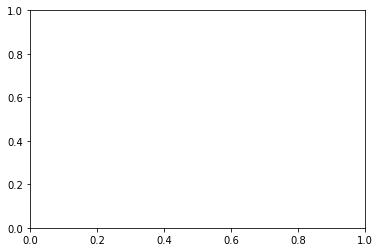

In [12]:

fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'./graphs1/loss_lr_{lr}_long.png')
print(f'./graphs1/loss_lr_{lr}.png')

## AUC

NameError: name 'cnn_dr' is not defined

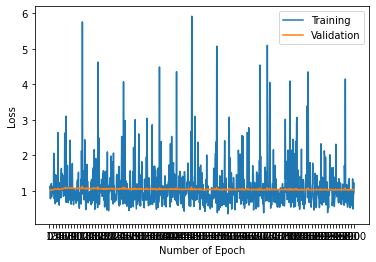

In [ ]:
fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}, cnn_dr:{cnn_dr}, cnn_dr:{fc_dr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()

In [ ]:
test_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, collate_fn=collate_padded_batch ,num_workers=8)

In [ ]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

model.load_state_dict(torch.load('saved_weights/training_torch_simple_mask_copy_split_model_128f64n-spe30-rand5-100e'))

output = []
model.eval()
with torch.no_grad():

    for x, y in test_loader:
        x_batch = torch.squeeze(x, 0).to(device)
        y_batch = y.to(device)
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        pred = model(x_batch.float())
        output.append(pred)
        
original_value_output = np.exp(output)

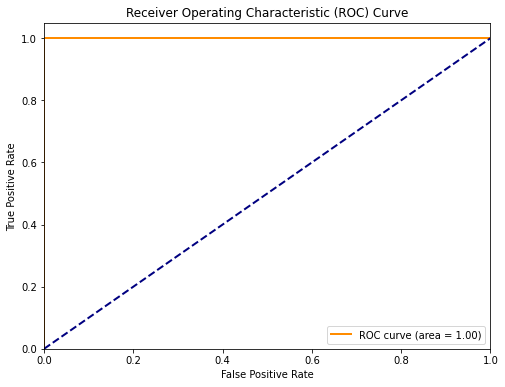

AUC Score: 1.0


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

def calculate_auc(labels, scores):
    """
    Calculate the Area Under the Receiver Operating Characteristic Curve (AUC)
    given true binary labels and prediction scores.
    
    :param labels: List of true binary labels (0 or 1).
    :param scores: List of prediction scores (probabilities or continuous output of the model).
    :return: AUC score.
    """
    auc_score = roc_auc_score(labels, scores)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return auc_score

# Example usage
true_labels = [0, 1, 1, 0, 1]  # True binary labels
prediction_scores = [0.1, 0.4, 0.8, 0.3, 0.7]  # Prediction scores or probabilities

auc_score = calculate_auc(true_labels, prediction_scores)
print(f"AUC Score: {auc_score}")

# testing out hyper-parameters

143

In [30]:
import subprocess

def run_bash_command(command):
    """
    Runs a bash command and returns its output.
    
    :param command: The command to run as a string.
    :return: A tuple containing the command's stdout and stderr.
    """
    try:
        # Run command
        result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        
        # Return stdout and stderr
        return result.stdout, result.stderr
    except subprocess.CalledProcessError as e:
        # Handle errors in the called executable
        return e.stdout, e.stderr
    except Exception as e:
        # Handle other errors related to subprocess.run()
        return None, str(e)

# Example usage
stdout, stderr = run_bash_command('nvidia-smi')
print('STDOUT:', stdout)
print('STDERR:', stderr)

# Example of a command that generates an error
stdout, stderr = run_bash_command('ls non_existent_file')
print('STDOUT:', stdout)
print('STDERR:', stderr)

STDOUT: Wed Mar 13 14:25:13 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:41:00.0 Off |                    0 |
| N/A   53C    P0    50W / 250W |   6455MiB / 32510MiB |     48%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               


In [14]:

def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f">> {appendix}, Epoch: {epoch}, LR: {lr}, cnnDR: {cnndr},  fnDR: {fcdr}, l2decay: {l2}\n")
        f.write(f"--- Train Loss: {train_loss}\n")
        f.write(f"--- Test Loss: {test_loss}\n")
        
def hyper_params_test(appendix, lr, fc_dr=0,cnn_dr=0, l2=0, epoch=50):
    print('lr:', lr, '| fc_dr:',  fc_dr, '| cnn_dr:', cnn_dr, '| l2:', l2, '==='*10)
    torch.cuda.empty_cache()
    import gc; gc.collect()
    
    # stdout, stderr = run_bash_command('nvidia-smi')
    # print('STDOUT:', stdout)
    # print('STDERR:', stderr)
    # model = Model(
    # num_classes=13,
    # num_filters=128,
    # num_conv_layers=2,
    # num_dense_neurons=64, # batch_size = 64
    # num_dense_layers=2,
    # return_logits=True,
    # dense_dropout_rate=fc_dr,
    # conv_dropout_rate=cnn_dr
    # ).to(device)
    
    model = Model(
    num_classes=13,
    num_filters=64,
    num_conv_layers=2,
    num_dense_neurons=256, # batch_size = 64
    # num_dense_neurons=128, # batch_size = 64
    num_dense_layers=2,
    return_logits=True,
    conv_dropout_rate=cnn_dr,
    dense_dropout_rate=fc_dr
    ).to(device)

    # stdout, stderr = run_bash_command('nvidia-smi')
    # print('STDOUT:', stdout)
    # print('STDERR:', stderr)
    
    epoch = epoch
    batch_size = 128
    lr = lr

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch)
    test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch)
    # criterion = nn.MSELoss()
    criterion = masked_MSE
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)
    
    ic.disable()
    # ic.enable()
    train_epoch_loss = []
    test_epoch_loss = []

    for e in tqdm(range(1, epoch+1)):
        model.train()
        train_batch_loss = []
        test_batch_loss = []
        
        for x, y in train_loader:
            x_batch = torch.squeeze(x, 0).to(device)
            y_batch = y.to(device)
            x_batch = x_batch.float()
            y_batch = y_batch.float()
            pred = model(x_batch.float())
            loss_train = criterion(y_batch, pred)
            ic(loss_train)
            train_batch_loss.append(loss_train)
    
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')
        train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
        with torch.no_grad():
            # print('test')
            for x, y in test_loader:
                x_batch = x.to(device)
                y_batch = y.to(device)
                pred = model(x_batch.float())
                loss_test = criterion(y_batch, pred)
                test_batch_loss.append(loss_test)
            test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
    x = np.arange(1, epoch+1, 1)
    fig, ax = plt.subplots(facecolor = 'white')
    ax.plot(x, train_epoch_loss,label='Training')
    ax.plot(x, test_epoch_loss,label='Validation')
    ax.legend()
    ax.set_xlabel("Number of Epoch")
    ax.set_ylabel("Loss")
    ax.set_xticks(np.arange(0, epoch+1, 10))
    ax.set_title(f'Loss: Learning_rate:{lr}, cnn_dr:{cnn_dr}, fc_dr:{fc_dr}')
    # ax_2 = ax.twinx()
    # ax_2.plot(history["lr"], "k--", lw=1)
    # ax_2.set_yscale("log")
    # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
    ax.grid(axis="x")
    fig.tight_layout()
    fig.show()
    fig.savefig(f'./graphs2/{appendix}_loss_lr_{lr}_cnn_dr_{cnn_dr}_fc_dr_{fc_dr}_l2{l2}.png')
    save_to_file('trials3.txt', appendix ,epoch, lr, cnn_dr, fc_dr, l2, train_epoch_loss, test_epoch_loss)
    print(f'./graphs2/{appendix}_loss_lr_{lr}_cnn_dr_{cnn_dr}_fc_dr_{fc_dr}_l2{l2}.png')
    
    torch.save({
    'optimizer': optimizer.state_dict(),
    'model': model.state_dict(),
}, '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/seq-{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}.pth')

In [15]:
torch.cuda.empty_cache()
import gc; gc.collect()

epoch = 250
for lr in [1e-4]:
    for fc_dr in [0.2]:
        for decay in [1e-9]:
            for cnn_dr in [0.2, 0.3, 0.4, 0.5]:
                hyper_params_test('64-2-256-2-128-log-reg', lr, cnn_dr = 0, fc_dr=fc_dr, l2=decay, epoch=epoch)

# epoch = 44
# for lr in [1e-4]:
#     for fc_dr in [0.4]:
#         for cnn_dr in [0.4]:
#             for decay in [1e-8]:
#                 hyper_params_test('final_model', lr, fc_dr=fc_dr, cnn_dr=cnn_dr, l2=decay, epoch=epoch)

# epoch = 50
# for lr in [1e-4]:
#     for fc_dr in [0.4]:
#         for cnn_dr in [0, 0.2, 0.3, 0.4, 0.5]:
#             for decay in [1e-8]:
#                 hyper_params_test('64-2-256-2-128-log-reg', lr, fc_dr=fc_dr, cnn_dr=cnn_dr, l2=decay, epoch=epoch)

lr: 0.0001 | fc_dr: 0.2 | cnn_dr: 0 | l2: 1e-09 ==============================


  0%|          | 0/250 [00:00<?, ?it/s]

  2%|▏         | 5/250 [05:51<4:47:26, 70.40s/it]


KeyboardInterrupt: 

lr: 0.004 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:21<00:00, 55.09s/it]


lr: 0.005 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:24<00:00, 55.23s/it]


lr: 0.007 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:13<00:00, 54.66s/it]


lr: 0.008 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:10<00:00, 54.54s/it]


lr: 0.0085 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:20<00:00, 55.00s/it]


lr: 0.0095 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:13<00:00, 54.69s/it]


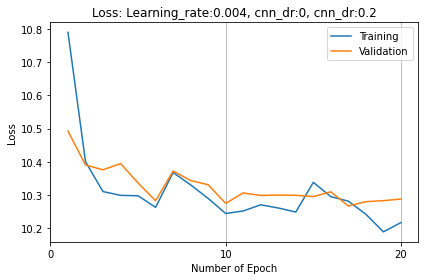

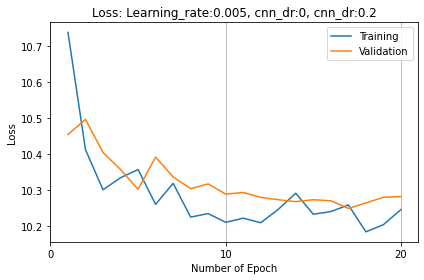

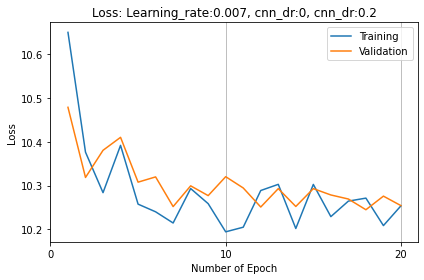

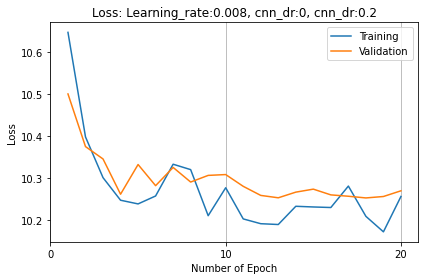

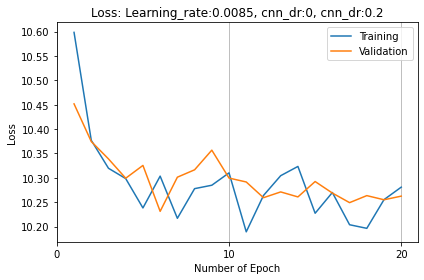

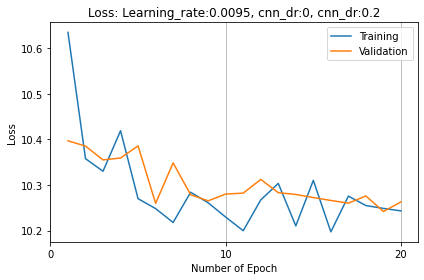

In [ ]:
# for x in np.arange(0.0000,0.0101,0.0005):
for x in [0.004,0.005, 0.007,0.008,0.0085, 0.0095]:
    if x == 0:
        continue
    else:
        hyper_params_test(x, epoch=20)

In [ ]:
# for x in np.arange(0.0000,0.0101,0.0005):
for x in [0.004,0.005, 0.007,0.008,0.0085, 0.0095]:
    if x == 0:
        continue
    else:
        hyper_params_test(x, epoch=20)

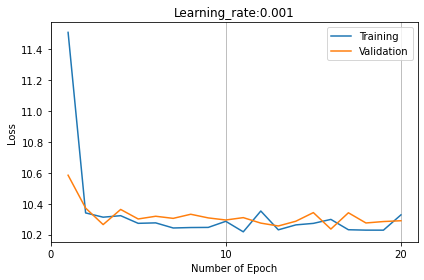

In [ ]:
#%%
fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
#%%
# a = torch.zeros(1, 2, 3, 4, 5, 6)
# b = a.view(a.shape[:2], -1, a.shape[5:])
# %%
# from torchviz import make_dot
# x = torch.randn(2, 4, 56).to(device)
# m = model_torch_simple.raw_seq_model().to(device)
# y = m(x)
# make_dot(y, params=dict(list(m.named_parameters()))).render("cnn_torchviz", format="png")

# Testing

In [15]:
testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader = DataLoader(dataset=testing_dataset, batch_size=128, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)

In [ ]:
pd.read_csv

In [23]:

save_path = '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models_old/aa-model_final1.pth'

# Load the saved file
checkpoint = torch.load(save_path)
ic.disable()

# Initialize the model and optimizer
model = Model(
num_classes=13,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=True,
conv_dropout_rate=0,
dense_dropout_rate=0.2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)

# optimizer = optimizer_class(model.parameters(), ...)  # Add the necessary arguments as per your optimizer's initialization method

# Load the model and optimizer states
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Make sure to call .eval() or .train() on your model depending on what you're planning to do next
model.eval()  # For inference
# or
# model.train()  # For further training


pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader:
        x_batch = torch.squeeze(x_test, 0).to(device)
        x_batch = x_batch.float()
        y_batch = y_test.float().to(device)
        # print(x_batch.size())
        # y_batch = torch.Tensor.float(y).to(device)
        # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
        pred = model(x_batch.float())
        pred_list.append(pred)
        target_list.append(y_batch)
        # pred = pred.unsqueeze(0)
        loss_test = criterion(y_batch, pred)
        mse_list.append(loss_test)
        # test_batch_loss.append(loss_test)
        # test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())


RuntimeError: Error(s) in loading state_dict for Model:
	Unexpected key(s) in state_dict: "feature_extraction_layer.2.weight", "feature_extraction_layer.2.bias", "feature_extraction_layer.2.running_mean", "feature_extraction_layer.2.running_var", "feature_extraction_layer.2.num_batches_tracked", "conv_layers.0.2.weight", "conv_layers.0.2.bias", "conv_layers.0.2.running_mean", "conv_layers.0.2.running_var", "conv_layers.0.2.num_batches_tracked", "conv_layers.1.2.weight", "conv_layers.1.2.bias", "conv_layers.1.2.running_mean", "conv_layers.1.2.running_var", "conv_layers.1.2.num_batches_tracked", "dense_layers.0.2.weight", "dense_layers.0.2.bias", "dense_layers.0.2.running_mean", "dense_layers.0.2.running_var", "dense_layers.0.2.num_batches_tracked", "dense_layers.1.2.weight", "dense_layers.1.2.bias", "dense_layers.1.2.running_mean", "dense_layers.1.2.running_var", "dense_layers.1.2.num_batches_tracked". 
	size mismatch for conv_layers.0.1.weight: copying a param with shape torch.Size([96, 64, 3]) from checkpoint, the shape in current model is torch.Size([96, 64, 12]).
	size mismatch for conv_layers.1.1.weight: copying a param with shape torch.Size([144, 96, 3]) from checkpoint, the shape in current model is torch.Size([144, 96, 12]).

In [31]:
testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)


save_path = '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models_old/aa-model_final1.pth'

# Load the saved file
checkpoint = torch.load(save_path)
ic.disable()

# Initialize the model and optimizer
model = Model(
num_classes=13,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=True,
conv_dropout_rate=0,
dense_dropout_rate=0.2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)

# optimizer = optimizer_class(model.parameters(), ...)  # Add the necessary arguments as per your optimizer's initialization method

# Load the model and optimizer states
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Make sure to call .eval() or .train() on your model depending on what you're planning to do next
model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(pred.detach().cpu().numpy()) 
        target_list.append(y_test.detach().cpu().numpy())

RuntimeError: Error(s) in loading state_dict for Model:
	Unexpected key(s) in state_dict: "feature_extraction_layer.2.weight", "feature_extraction_layer.2.bias", "feature_extraction_layer.2.running_mean", "feature_extraction_layer.2.running_var", "feature_extraction_layer.2.num_batches_tracked", "conv_layers.0.2.weight", "conv_layers.0.2.bias", "conv_layers.0.2.running_mean", "conv_layers.0.2.running_var", "conv_layers.0.2.num_batches_tracked", "conv_layers.1.2.weight", "conv_layers.1.2.bias", "conv_layers.1.2.running_mean", "conv_layers.1.2.running_var", "conv_layers.1.2.num_batches_tracked", "dense_layers.0.2.weight", "dense_layers.0.2.bias", "dense_layers.0.2.running_mean", "dense_layers.0.2.running_var", "dense_layers.0.2.num_batches_tracked", "dense_layers.1.2.weight", "dense_layers.1.2.bias", "dense_layers.1.2.running_mean", "dense_layers.1.2.running_var", "dense_layers.1.2.num_batches_tracked". 

## Mic calc

In [19]:
pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (pred_list - target_list)**2
mse_out = np.nanmean(mse_list, axis=0)
print(mse_out)
print(np.mean(mse_out))

[ 2.9145053  12.74587957  9.116041   21.672894    1.21607873  1.16963101
  6.94100846  1.97656457  1.41356874  1.2116017   3.31887445  6.7727877
  7.01459885]
5.960310315509801


In [20]:
mse_out

array([ 2.9145053 , 12.74587957,  9.116041  , 21.672894  ,  1.21607873,
        1.16963101,  6.94100846,  1.97656457,  1.41356874,  1.2116017 ,
        3.31887445,  6.7727877 ,  7.01459885])

In [18]:
pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (np.exp(pred_list) - np.exp(target_list))**2
mse_out = np.nanmean(mse_list, axis=0)
print(mse_out)
print(np.mean(mse_out))

[33.7704982   1.00935202  1.06276192  1.01825593 32.92269494 22.44298034
 20.98731605 65.93327374  9.02158095  0.41475623  3.12617911 43.22211859
  2.98510831]
18.301298179309352


## Ea calc

In [176]:
def find_range_vectorized(target_values, quest_values):
    # Convert lists to numpy arrays for efficient broadcasting
    target_values =  np.exp(np.array(target_values)) # Reshape for broadcasting
    quest_values =  np.exp(np.array(quest_values))

    # Perform broadcasting to compare each quest value against all target values
    # This creates a boolean matrix where rows correspond to target values and columns to quest values
    in_range_matrix = (target_values / 2 <= quest_values) & (quest_values <= target_values * 2)
    # in_range_matrix = np.abs(np.log2(target_values) - np.log2(quest_values))
    # in_range_matrix  = in_range_matrix  <= 1
    
    # print(mse)
    return in_range_matrix
# Example usage
# target_values = [[10, 20, 30, 40, 50], [10, 20, 30, 40, 50]]
# quest_values = [[25, 5, 60, 1, 1], [10, 20, 30, 40, 50]]
result = find_range_vectorized(target_list, pred_list)

In [174]:
target_values_ =  np.exp(np.array(target_list)) # Reshape for broadcasting
quest_values_ =  np.exp(np.array(pred_list))


In [ ]:
drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']


In [178]:
print(np.nanmean(result, axis=0))

[0.59784411 0.67247098 0.45854063 0.50746269 0.7106136  0.64510779
 0.41293532 0.56467662 0.74626866 0.77280265 0.64013267 0.53067993
 0.69402985]


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score


for i in range(result.shape[0]):
    f1 = f1_score(y_true, result[i, :])
    accuracy = accuracy_score(y_true, result[i, :])
    print(f"Model {i+1} - F1 Score: {f1}, Accuracy: {accuracy}")


In [ ]:
def EA_calc(target_matrix: np.array):
    drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    for x, drug in zip(range(target_matrix.shape[1]), drugs):
        ea_count = len([item for item in target_matrix[:,x] if item == True])
        ea_rate = (ea_count / len(target_matrix[:,x])) * 100
        print(drug, ea_rate)
        
def MSE_calc(target_matrix: np.array):
    drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    for x, drug in zip(range(target_matrix.shape[1]), drugs):
        mse = np.mean(target_matrix[:,x])
        print(drug, mse)
        

# Explanable AI

### Sensitivity analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assume `input_data` is your input tensor, and `feature_index` is the index of the feature to perturb
perturbation_range = np.linspace(0, 1, num=20)  # Example range of perturbation
original_value = input_data[0, feature_index].item()  # Store original value

output_changes = np.zeros((len(perturbation_range), 13))  # Store changes in outputs

for i, perturb in enumerate(perturbation_range):
    input_data[0, feature_index] = original_value + perturb  # Perturb feature value
    with torch.no_grad():
        outputs = model(input_data).numpy()  # Get model output
    output_changes[i] = outputs  # Record the change

# Reset the perturbed feature to its original value
input_data[0, feature_index] = original_value

# Example analysis for one output
plt.figure(figsize=(10, 6))
for output_index in range(13):
    plt.plot(perturbation_range, output_changes[:, output_index], label=f'Output {output_index+1}')

plt.xlabel('Perturbation')
plt.ylabel('Output Change')
plt.title('Sensitivity Analysis of Feature X on All Outputs')
plt.legend()
plt.show()


### SHAP

In [ ]:
import torch
import numpy as np

def model_wrapper(x):
    with torch.no_grad():
        # Convert the input numpy array to a PyTorch tensor
        tensor_x = torch.tensor(x, dtype=torch.float32)
        # Make a prediction with your model
        model_output = model(tensor_x)
        # Convert the prediction back to a numpy array
        return model_output.numpy()


In [ ]:
import shap

# Sample data for initialization (e.g., a batch from your training data)
X_sample = np.array([...])  # Replace with your actual numpy array

# Initialize the explainer
explainer = shap.KernelExplainer(model_wrapper, X_sample)

# Choose the instance you want to explain
X_instance = np.array([...])  # Replace with the instance in numpy array format

# Calculate SHAP values
shap_values = explainer.shap_values(X_instance)

# Plotting the SHAP values
shap.initjs()  # Initializes JavaScript visualization in Jupyter Notebooks
shap.force_plot(explainer.expected_value, shap_values, X_instance)


### Counterfactual

In [ ]:
### SHAP